# Chapter 2: More on PyMC3

### Model context

- Model variables are associated with a model by defining them in context.

`parameter` -> Exponentially distributed r.v.

`data_generator` -> Poisson distributed r.v. with $\lambda$=`parameter`

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
plt.style.use('bmh')

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [3]:
with model: # To pick up a model again later
    data_plus_one = data_generator + 1 # Pois RV + 1

In [5]:
# Can examine variables outside of model context
parameter.tag.test_value # Initial value of variable
# ^ Can be specified at variable creation time

array(0.49999999904767284)

- Multiple models can be manipulated simultaneously

In [6]:
# Manipulating a separate model:
with pm.Model() as ab_testing:
    sigma = pm.Normal('std', 0, 1)
    p_A = pm.Uniform('p(A)', 0, 1)

Types of programming variables in PyMC3:
- Stochastic variables: variables drawn from a probability distribution (i.e. random variables).
- Deterministic variables: variables that are not random if the variables' parameters and components are known.

### Stochastic Variables

In [10]:
with pm.Model() as model:
    some_variable = pm.DiscreteUniform('discrete_uni_var', 0, 4)
    # Name attribute is used to retrieve posterior distribution later
    # Instead of initializing id. distr. variabels separately...
    # beta_1 = pm.Uniform('beta_1', 0, 1)
    # beta_2 = pm.Uniform('beta_2', 0, 1)
    # ... use the 'shape' argument!
    N = 10
    betas = pm.Uniform('betas', 0, 1, shape=N)


### Deterministic Variables

- Deterministic variables have known values if the parameters to the functions they evaluate from are known.

In [14]:
with model:
    deterministic_variables = pm.Deterministic('deterministic variables',
                                               some_variable*2)

In [5]:
with pm.Model() as model:
    lambda_1 = pm.Exponential('lambda_1', 1)
    lambda_2 = pm.Exponential('lambda_2', 1)
    tau = pm.DiscreteUniform('tau', lower=0, upper=10)

# Elementary operations implicitly create deterministic variables
new_deterministic_variable = lambda_1 + lambda_2
# if lambda_1 and lambda_2 are known, then we know new_det...

In [4]:
n_data_points = 5
idx = np.arange(n_data_points)
with model:
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)
    
# lambda_ is deterministic
# if we know tau, lambda_1, lambda_2, we know lambda_

NameError: name 'model' is not defined

- Stochastic variables behave like scalars/numpy arrays within deterministic variables -> can use Theano's tensor operations on them.

In [17]:
def multiply(x, y):
        return np.multiply(x, y) # Hadamard product

with model:
    stoch_1 = pm.Uniform('U_1', 0, 1)
    stoch_2 = pm.Uniform('U_2', 0, 1)

    det_1 = pm.Deterministic('Product', multiply(stoch_1, stoch_2))

### Theano

- Theano builds a compute graph that can be executed at a time of our choosing using `eval()`
- Compute graph is desirable because:
    - We can easily simplify operations
    - We can compile the graph to C
    - We can compile to run on a GPU
    
"PyMC3 is basically a collection of `theano` symbolic expressions for various probability distributions that are combined to one big compute graph making up the whole model log probability, and a collection of inference algorithms that use that graph to compute probabilities and gradients"

In [ ]:
# PyMC3 code with Theano spice
import theano.tensor as tt

with pm.Model() as theano_test:
    p1 = pm.Uniform('p', 0, 1) # Theano variable
    p2 = 1 - p1 # ... another Theano variable
    p = tt.stack([[p1, p2]]) # Combines into one Theano variable (a vector)
    # p are category probabilities
    assignment = pm.Categorical('assignment', p) 

### Including observations in the Model

In [ ]:
samples = [lambda_1.random()[0] for i in range(20000)]
plt.hist(samples, bins=70, normed=True, histtype='stepfilled')
plt.title('Prior distribution for $\lambda_1$')
plt.xlim(0, 8);
plt.ylabel('f(x)'); plt.xlabel('x');

1. Get 20 000 samples of `lambda_1`, an Exponential distributed r.v.
2. Plot the observations in a normed histogram $\implies$ plot of the probability density function of the r.v.

To specify the initial values an r.v. takes on, pass the desired values as a `np` or `pd` array to the `observed` argument of the relevant distribution's function.

In [16]:
data = np.array([10, 5])
with model:
    fixed_variable = pm.Poisson('fxd', 1, observed=data)
print('value: ', fixed_variable.tag.test_value)

value:  [10  5]


In [19]:
data = np.array([10, 25, 15, 20, 35])
with model:
    obs = pm.Poisson('obs', lambda_, observed=data)
print(obs.tag.test_value)

[10 25 15 20 35]


## Modeling approaches

- Start by thinking about how your data might have been generated: how would you recreate the data?

Text messaging Poisson process modeling example:
1. What is the best random variable to describe this count data? A Poisson r.v. was a good choice because it can count the total occurences of an event in a timeframe (e.g. a day).
2. Next, what are the parameters of the Poisson distribution? Here there's only one: the rate parameter, $\lambda$.
3. Is $\lambda$ known? No, it was though there might be two different values for $\lambda$, one for earlier in the time series and one for later. We think it might switch at some point, but we're not sure when. Call the switchpoint $\tau$.
4. What is a good distribution for the Poisson parameters? The Exponential is good, as it assigns probabilities to positive real numbers only. The Exponential distribution also has a parameter too though, $\alpha$.
5. We don't know $\alpha$, nor do we really know what $\alpha$ might be. Here we draw the line, and assign $\alpha$ a fixed value.

What is a good value for $\alpha$? Using our data, we can establish that the $\lambda$ values are between 10-30, so we should choose $\alpha$ such that the mean of $\lambda$ given $\alpha$ is equal to the observed mean.

We also need to figure out how what $\tau$ might be. We could guess this, but a Discrete Uniform distribution over the timespan is just fine.

<img src='http://i.imgur.com/7J30oCG.png'/>

This is a graph of our model. We can think of this as a data-generation 'story': $\alpha$ is used to generate two Poisson parameters from an Exponential distribution, which constitute the distribution of the rate parameter over the entire time series. $\tau$ contributes to this distribution by indicating when the switchover occurs.

If we reverse the above derivation of how the data might have been generated, we can create our own data generation process.

1. Get a switchover value.

In [20]:
tau = np.random.randint(0, 80) # Value of a Uniform dist r.v.
print(tau)

9


/2. Draw two rate parameters from an Exponential distribution.

In [21]:
alpha = 1./20.
lambda_1, lambda_2 = np.random.exponential(scale=1/alpha, size=2)
print(lambda_1, lambda_2)

12.8061154188 6.20251122955


/3. Make observations according to these Poisson distributions before and after the switchover.

In [25]:
data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size=80-tau)]

/4. Plot the artificial data:

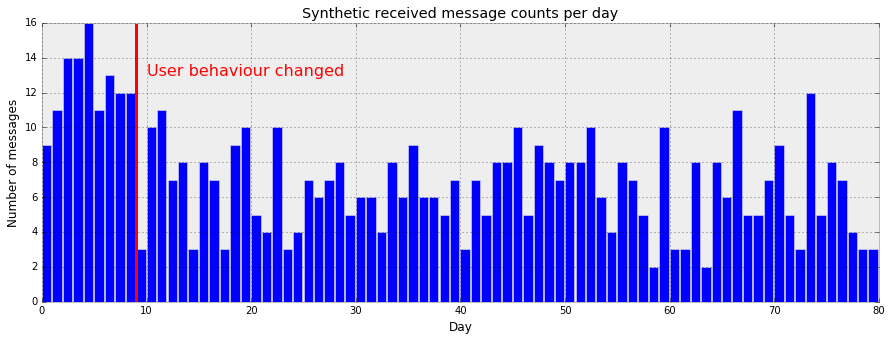

In [47]:
plt.figure(figsize=(15, 5))
plt.title('Synthetic received message counts per day')
plt.bar(range(80), data, width=0.9)
plt.xlabel('Day'); plt.ylabel('Number of messages')
plt.axvline(x=tau, ymax=max(data), color='r', lw=3);
plt.text(tau+1, max(data)-3, 'User behaviour changed', color='r', size=16);

PyMC3 is designed to find parameters that will match our generated data against our observed data.

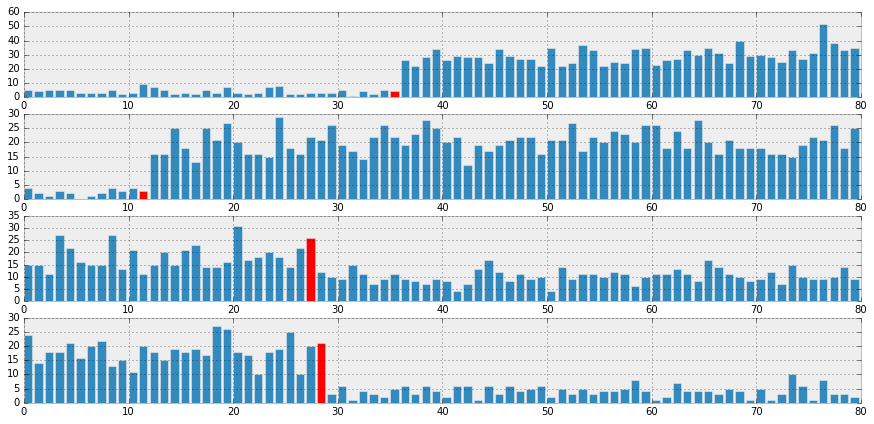

In [50]:
def plot_artificial_sms_dataset():
    tau = stats.randint.rvs(0, 80)
    alpha = 1./20.
    lambda_1, lambda_2 = stats.expon.rvs(scale=1/alpha, size=2)
    data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size=80 - tau)]
    plt.bar(np.arange(80), data, color="#348ABD")
    plt.bar(tau - 1, data[tau-1], color="r", label="user behaviour changed")
    plt.xlim(0, 80);

plt.figure(figsize=(15, 7))
plt.title("More example of artificial datasets")
for i in range(4):
    plt.subplot(4, 1, i+1)
    plot_artificial_sms_dataset()

### Example: Bayesian A/B testing

- 'A/B testing is an experiment design for determining the difference of effectiveness between two different treatments'
- To create a Bayesian model, we need prior distributions for our unknown quantities. If we have no persuasions towards any particular value, a Uniform distribution is perfectly OK.

Scenario: Users visiting website A, seeking the true probability - $p_A$ - that visitors purchase something from the website. $N$ visitors to site A. $n$ buy something.

In [83]:
import pymc as pm

p = pm.Uniform('p', lower=0, upper=1)

In [95]:
# True pA = 0.05, N = 1500
# Will simulate whether users made a purchase or not
# X is r.v. for purchase count
# X ~ Bern(pA)

p_true = 0.05 # Is actually unknown
N = 1500
occurences = pm.rbernoulli(p_true, N) # array of observations
print(occurences.sum()/N) # Nb. != p_true!

0.046


 [-----------------100%-----------------] 18000 of 18000 complete in 11.2 sec

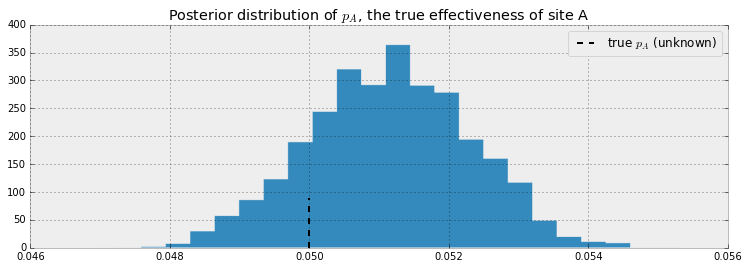

In [97]:
# Combine observations into a PyMC variable
obs = pm.Bernoulli('obs', p, value=occurences, observed=True)
# Run inference algorithm (Markov Chain Monte Carlo)
mcmc = pm.MCMC([p, obs])
mcmc.sample(18000, 1000)

plt.figure(figsize=(12.5, 4))
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(mcmc.trace("p")[:], bins=25, histtype="stepfilled", normed=True)
plt.legend();

### A and B together

In [115]:
# What's the difference between pA and pB?

true_p_A = 0.1
true_p_B = 0.04

N_A = 1500
N_B = 750

observations_A = pm.rbernoulli(true_p_A, N_A)
observations_B = pm.rbernoulli(true_p_B, N_B)

In [116]:
observations_A.mean()

0.097333333333333327

In [117]:
observations_B.mean()

0.048000000000000001

In [118]:
# set up pymc model
# Prior probabilities
p_A = pm.Uniform('p_A', 0, 1) # because we don't know anything
p_B = pm.Uniform('p_B', 0, 1)

@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

# Observation variables
obs_A = pm.Bernoulli('obs_A', p_A, value=observations_A, observed=True)
obs_B = pm.Bernoulli('obs_B', p_B, value=observations_B, observed=True)

# Inference algo
mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 3.1 sec

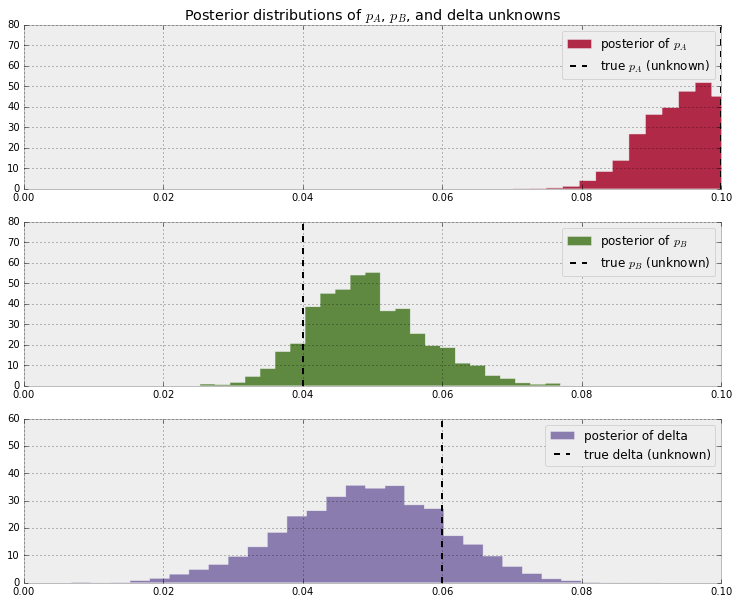

In [119]:
p_A_samples = mcmc.trace('p_A')[:]
p_B_samples = mcmc.trace('p_B')[:]
delta_samples = mcmc.trace('delta')[:]

plt.figure(figsize=(12.5, 10))

# histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

- Posterior of $p_A$ is lankier than the posterior of $p_B$: this is because we have more observations for site $A$.

In [120]:
(delta_samples < 0).mean() # Observations for which B > A

0.0

In [121]:
(delta_samples > 0).mean() # Observations for which A > B

1.0

Recap on what we did:
- Randomly sampled prior probabilities for people buying from the sites from Uniform distributions
- Incorporated synthetic observations into our model using Bernoulli variables for buy/did not buy
- Ran a Markov Chain Monte Carlo simulation (magic?)
- Resulted in distributions of posterior probabilities: the estimated p_A and p_B from the MCMC simulation.

Bayesian inference $\implies$ Updating our beliefs based on new information. Here we informed our beliefs that people would buy from sites A and B, and which site performs better.

### An Algorithm for Human Deceit

Binomial distribution, $k$ successes in $N$ trials.

$$
    P(X = k) = {{N}\choose{k}}p^{\ k}(1-p)^{\ N-k}
$$

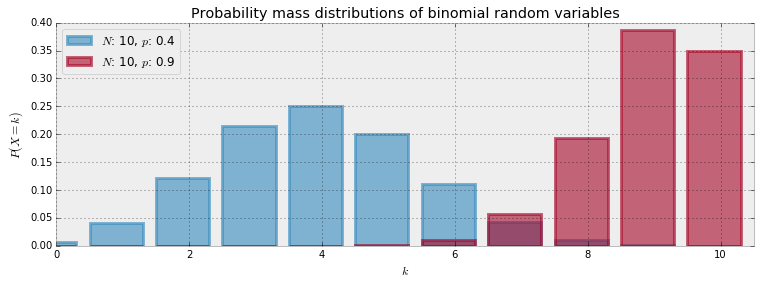

In [9]:
# Using Scipy's stats module to plot the PMF of two Binomial
# distributions - one for which p = 0.4 and one for which
# p = 0.9.

plt.figure(figsize=(12.5, 4))

import scipy.stats as stats
binomial = stats.binom

parameters = [(10, .4), (10, .9)]
colors = ['#348ABD', '#A60628']

for i in range(2):
    N, p = parameters[i]
    _x = np.arange(N + 1)
    plt.bar(_x - 0.5, binomial.pmf(_x, N, p), color=colors[i],
            edgecolor=colors[i],
            alpha=0.6,
            label="$N$: %d, $p$: %.1f" % (N, p),
            linewidth=3)

plt.legend(loc="upper left")
plt.xlim(0, 10.5)
plt.xlabel("$k$")
plt.ylabel("$P(X = k)$")
plt.title("Probability mass distributions of binomial random variables");

### Example: Cheating among students 

In [ ]:
# Determine the frequency of students cheating during an
# exam
# X -> r.v. for 'Yes I did cheat'
# Informing prior p against this this

100 students are being surveyed for cheating.
We wish to find $p$, the proportion of cheaters. We are ignorant about $p$, so we assign at Uniform prior:

The interview process involves the child flipping a coin: 
   - If the first flip is heads, the child must tell the truth
   - If tails, the coin is flipped another time. If the second flip is heads, the chilld must say they cheated, otherwise they must say they did not cheat.

In [15]:
import pymc3 as pm
import theano.tensor as tt

N = 100
with pm.Model() as model:
    p = pm.Uniform('freq_cheating', 0, 1) # Cheating prior
    true_answers = pm.Bernoulli('truths', p, shape=N, # Synthetic true cheating rate
                                testval=np.random.binomial(1, .5, N))
    first_coin_flips = pm.Bernoulli('first_flips', 0.5, shape=N,
                                    testval=np.random.binomial(1, 0.5, N))
    second_coin_flips = pm.Bernoulli('second_flips', 0.5, shape=N,
                                    testval=np.random.binomial(1, 0.5, N))
    val = (first_coin_flips*true_answers + # Honest 'I cheated' answers
               (1 - first_coin_flips)*second_coin_flips) # Possibly fake 'I cheated' answers
    observed_proportion = pm.Deterministic("observed_proportion",
                                           tt.sum(val)/float(N)) # Observed cheat count

In [16]:
# Say we perform our interviews, and we receive 35
# 'yes' responses.
X = 35

with model:
    observations = pm.Binomial('obs', N, observed_proportion,
                              observed=X)

In [17]:
with model:
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(40000, step=step)
    burned_trace = trace[15000:]

  0%|                                    | 99/40000 [06:37<43:52:06,  3.96s/it]

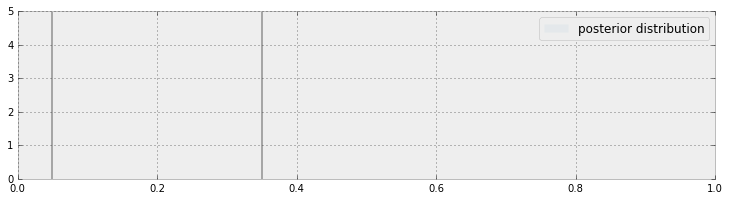

In [18]:
plt.figure(figsize=(12.5, 3))
p_trace = burned_trace['freq_cheating'][15000:]
plt.hist(p_trace, histtype='stepfilled', normed=True, alpha=0.05,
         bins=30, label='posterior distribution', color='#348ABD')
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend()

$$
    \text{P('Yes') = P(Cheater) P(First flip is heads) + P(First flip is tails) P(Second flips is heads)} \\
    = p\frac{1}{2} + \frac{1}{4}
$$

In [19]:
with pm.Model() as model:
    p = pm.Uniform('freq_cheating', 0, 1)
    p_skewed = pm.Deterministic('p_skewed', 0.5*p + 0.25)

In [20]:
with model:
    yes_responses = pm.Binomial('number_cheaters', 100,
                                p_skewed, observed=35)

In [21]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(25000, step=step)
    burned_trace = trace[2500:]


  7%|██▋                                 | 1862/25000 [00:02<00:29, 792.39it/s]

100%|███████████████████████████████████| 25000/25000 [00:28<00:00, 873.13it/s]


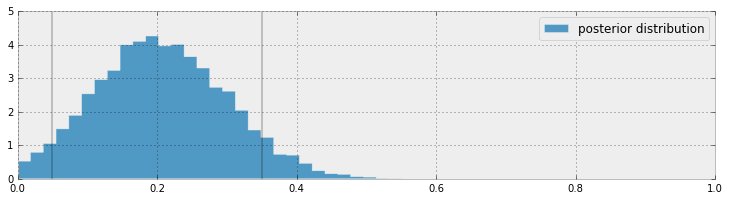

In [23]:
plt.figure(figsize=(12.5, 3))
p_trace = burned_trace["freq_cheating"]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.2)
plt.xlim(0, 1)
plt.legend();

#### Example: Challenger Space Shuttle Disaster

In [3]:
def figsize(width, height):
    return plt.figure(figsize=(width, height))

Temp (F), O-Ring failure?
[[ 66.   0.]
 [ 70.   1.]
 [ 69.   0.]
 [ 68.   0.]
 [ 67.   0.]
 [ 72.   0.]
 [ 73.   0.]
 [ 70.   0.]
 [ 57.   1.]
 [ 63.   1.]
 [ 70.   1.]
 [ 78.   0.]
 [ 67.   0.]
 [ 53.   1.]
 [ 67.   0.]
 [ 75.   0.]
 [ 70.   0.]
 [ 81.   0.]
 [ 76.   0.]
 [ 79.   0.]
 [ 75.   1.]
 [ 76.   0.]
 [ 58.   1.]]


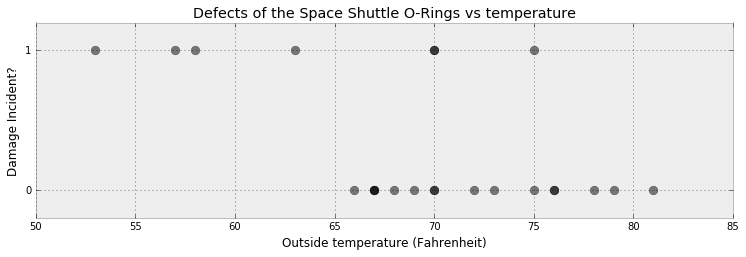

In [7]:
figsize(12.5, 3.5)
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("./Chapter2_MorePyMC/data/challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
# drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

# plot it, as a function of temperature (the first column)
print("Temp (F), O-Ring failure?")
print(challenger_data)

plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature");

At a given temperature, what is the probability of failure? -> Answer using logistic regression of Damage onto Temperature: fit the function:
$$ 
    p(t) = \frac{1}{1+e^{\ \beta t}}
$$
where $p$ is the probability of a Damage Incident, $t$ is the Outside Temperature, and $\beta$ is a parameter to make the model's probabilities reflect our observations.

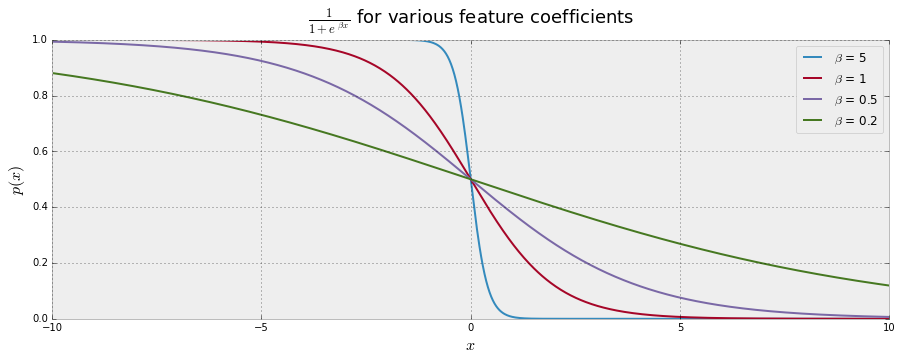

In [41]:
def logistic(x, beta, bias):
    return 1./(1. + np.exp(beta*x + bias))

# Plot the logistic function for various beta values
x = np.linspace(-10, 10, 1000)
figsize(15, 5)
for beta in [5, 1, 0.5, 0.2]:
    plt.plot(x, logistic(x, beta, 0), label=r'$\beta$ = %s' % str(beta));
    plt.hold('on')
plt.legend(); plt.title(r'$\frac{1}{1 + e^{\ \beta x}}$ for various feature coefficients', size=18, y=1.04);
plt.xlabel(r'$x$', size=16); plt.ylabel(r'$p(x)$', size=16);

We can shift the logistic function using a bias term:
$$
    p(x) = \frac{1}{1 + e^{\ \beta x + \alpha}}
$$

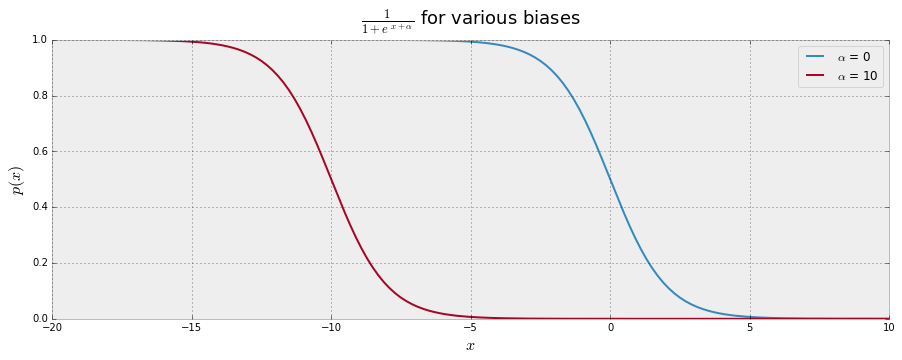

In [48]:
x = np.linspace(-100, 100, 1000)
figsize(15, 5)
for bias in [0, 10]:
    plt.plot(x, logistic(x, 1, bias), label=r'$\alpha$ = %s' % str(bias));
    plt.hold('on')
plt.legend(); plt.title(r'$\frac{1}{1 + e^{\ x + \alpha}}$ for various biases', size=18, y=1.04);
plt.xlabel(r'$x$', size=16); plt.ylabel(r'$p(x)$', size=16);
plt.xlim(-20, 10);

The scaling and bias terms have no reason to be positive, bounded, or around any particular value: apparently this implies that they are best model by a Normal r.v.

#### Normal Distributions

In [55]:
def normal(x, mu=0, var=1): # Returns the standard normal probability density at x
    return np.sqrt(var/(2*np.pi))*np.exp((-var*(x - mu)**2)/2)

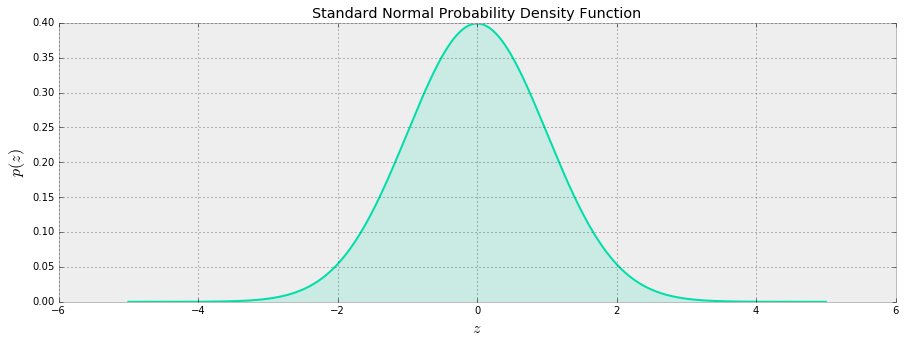

In [78]:
x = np.linspace(-5, 5, 1000)
figsize(15, 5)
plt.plot(x, normal(x, 0, 1), color='#00deaa');
plt.fill_between(x, normal(x, 0, 1), color='#00deaa', alpha=.15)
plt.title('Standard Normal Probability Density Function');
plt.xlabel(r'$z$', size=16); plt.ylabel(r'$p(z)$', size=16);

In [79]:
import pymc as pm

temperature = challenger_data[:, 0]
defect = challenger_data[:, 1]

beta = pm.Normal('beta', 0, 0.001, value=0)
alpha = pm.Normal('alpha', 0, 0.001, value=0)
# ^ Large beta or alpha cause p(x) to be close to 0 or 1, which PyMC doesn't like

@pm.deterministic
def p(t=temperature, alpha=alpha, beta=beta):
    return 1./(1 + np.exp(beta*t + alpha))

So we have a way of expressing the probability of failure for a given temperature. An O-ring being put through launch is a Bernoulli trial with outcomes of failing or not failing, with the probability of failure being described by the aforementioned Logistic function. This is important because the Bernoulli r.v.s (i.e. indicator r.v.s) offer a way to connect the model's Logistic function to our observations.

In [83]:
observed = pm.Bernoulli('bernoulli_obs', p, value=defect, observed=True)

model = pm.Model([observed, beta, alpha])

# Yet to be explained...
map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(120000, 100000, 2)

 [-----------------100%-----------------] 120000 of 120000 complete in 17.8 sec

The above fits our model, allowing us to sample from the posterior.

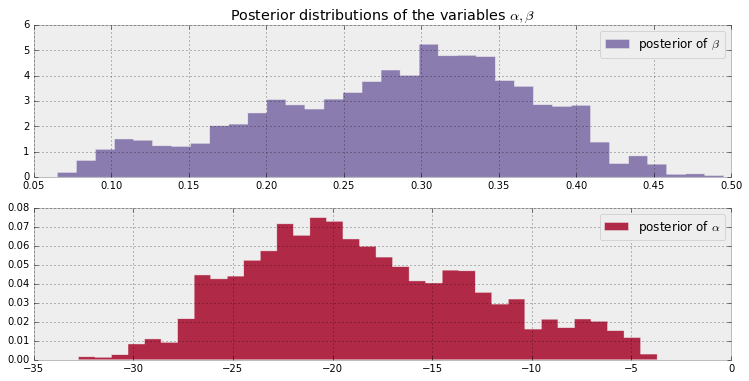

In [85]:
alpha_samples = mcmc.trace('alpha')[:, None]
beta_samples = mcmc.trace('beta')[:, None]

figsize(12.5, 6)

# histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", normed=True)
plt.legend();

Observations:
    - $\beta$ is certainly not zero, implying that temperature does influence probability of failure.
    - $\alpha$ certainly isn't zero either
    - The values of $\beta$ and $\alpha$ are very spread out - this reflects uncertainty, and our small sample size.

What is the expected probability of failure for a given temperature? The expectation of this probability is the mean of all posterior estimates, uniformly weighted.

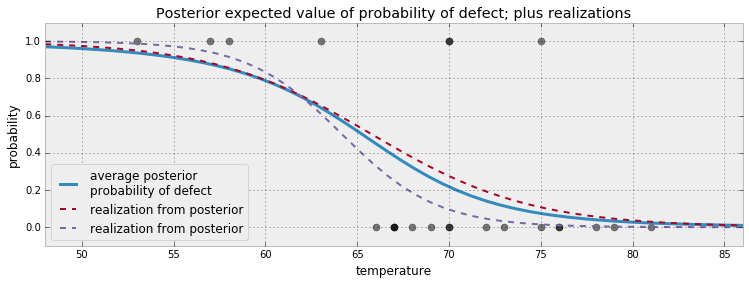

In [87]:
t = np.linspace(temperature.min() - 5, temperature.max() + 5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples) # Compute probability for each simulation estimate

mean_prob_t = p_t.mean(axis=0) # Expectation of these probabilities

figsize(12.5, 4)

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-2, :], ls="--", label="realization from posterior")
plt.scatter(temperature, defect, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; \
plus realizations")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("temperature");

In [89]:
p_t.shape

(10000, 50)

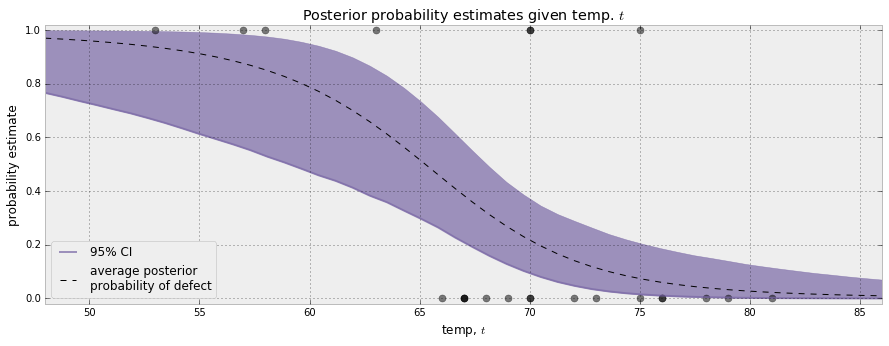

In [91]:
# Confidence intervals at each temperature?

from scipy.stats.mstats import mquantiles
figsize(15, 5)

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0) # p_t contains rows of estimates of failure prob. at temperature t
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")
# Quantiles are calculated on the columns of p_t - we fill in the middle 95% of estimated probability estimates

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(temperature, defect, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

On the day of the Challenger disaster the Outside Temperature was 30 degrees farenheit. We can see from the above analyses that this sadly didn't bode well for the launch. 

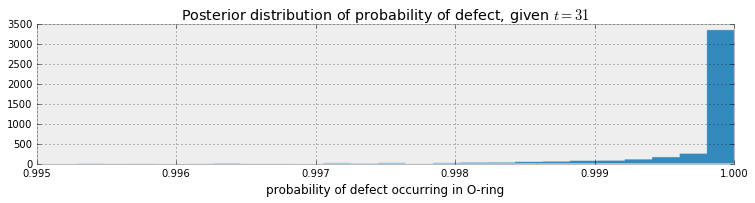

In [92]:
figsize(12.5, 2.5)
prob_31 = logistic(31, beta_samples, alpha_samples)

plt.xlim(0.995, 1)
plt.hist(prob_31, bins=1000, normed=True, histtype='stepfilled')
plt.title("Posterior distribution of probability of defect, given $t = 31$")
plt.xlabel("probability of defect occurring in O-ring");

#### Testing Goodness of Fit

How can we test whether our model is a bad fit? $\implies$ Simulate data generation using the model we created, then compare this with the observed data. If it's different, then we know our model is not a good fit for the data.

In [95]:
simulated_data = pm.Bernoulli('bernoulli_sim', p)
N = 10000

mcmc = pm.MCMC([simulated_data, alpha, beta, observed])
mcmc.sample(N)

 [-----------------100%-----------------] 10000 of 10000 complete in 3.0 sec

(10000, 23)


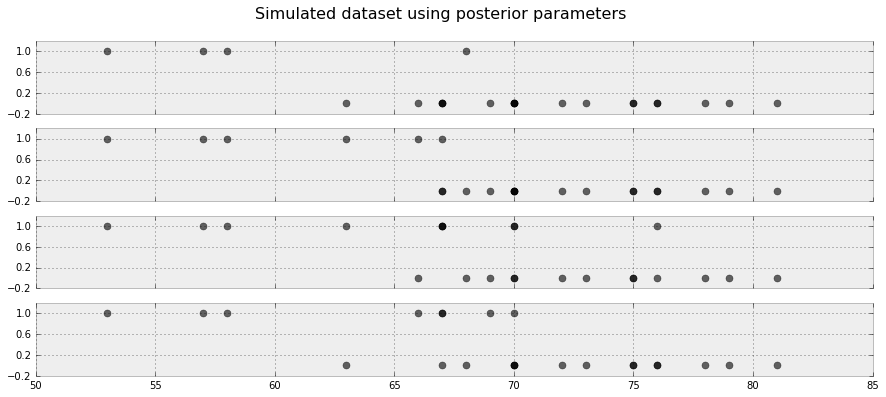

In [106]:
simulations = mcmc.trace("bernoulli_sim")[:]
print(simulations.shape)

f, axs = plt.subplots(4, 1, sharex=True, figsize=(15, 6))
plt.suptitle("Simulated dataset using posterior parameters", size=16)
for i in range(4):
    axs[i].scatter(temperature, simulations[1000 * i, :], color="k",
                    s=50, alpha=0.6);
    axs[i].set_yticks(np.arange(-0.2, 1.4, 0.4))

In [111]:
ix = np.argsort(posterior_probability)
print("probb | defect ")
for i in range(len(defect)):
    print("%.2f  |   %d" % (posterior_probability[ix[i]], defect[ix[i]]))

probb | defect 
0.00  |   0
0.01  |   0
0.01  |   0
0.02  |   0
0.02  |   0
0.03  |   0
0.03  |   1
0.06  |   0
0.08  |   0
0.16  |   1
0.16  |   0
0.16  |   0
0.17  |   1
0.24  |   0
0.29  |   0
0.39  |   0
0.39  |   0
0.40  |   0
0.49  |   0
0.74  |   1
0.95  |   1
0.97  |   1
0.99  |   1
